In [16]:
#import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pyarrow as pa
import seaborn as sns
from datetime import timedelta, datetime

dir = Path(r"S:\Fackler_OSS_364376\data\IRB-364376-v1-230215")

In [17]:
fp = dir.joinpath('EHR', 'd_flo_measures.csv.gz')
dict = pd.read_csv(fp, compression="gzip")
# dict.head()
# dict['disp_name'].unique

names = ["State Behavioral Scale",
"-3 Unresponsive", 
"-2 Responsive to noxious stimuli", 
"-1 Responsive to gentle touch or voice",
"0 Awake and Able to calm",
"+1 Restless and difficult to calm",
"+2 Agitated",
"State Behavioral Scale (SBS)"]

dict[dict['disp_name'].isin(names)]

,flo_meas_id,flo_meas_name,site_row_id,record_state_c,allow_comp_yn,disp_name,abbr_p,row_typ_c,chg_trg_type_c,val_type_c,...,flo_row_status_c,row_type,val_type,cross_enc_yn,question_id,question_prompt,question_required_yn,context_c,store_calc_data_yn,show_abbr_c
64810,304080015,G JHM IP PEDS STATE BEHAVIORAL SCALE,NaN,NaN,NaN,State Behavioral Scale,NaN,2.0,NaN,NaN,...,0.0,Flowsheet Group,NaN,N,NaN,NaN,NaN,1.0,NaN,NaN
64811,304080016,R JHM IP AD PEDS SB UNRESPONSIVE,NaN,NaN,NaN,-3 Unresponsive,NaN,1.0,NaN,8.0,...,0.0,Data,Custom List,N,NaN,NaN,NaN,1.0,NaN,NaN
64812,304080017,R JHM IP AD PEDS SB RESPONSIVE TO NOXIOUS STIMULI,NaN,NaN,NaN,-2 Responsive to noxious stimuli,NaN,1.0,NaN,8.0,...,0.0,Data,Custom List,N,NaN,NaN,NaN,1.0,NaN,NaN
64813,304080018,R JHM IP AD PEDS SB RESPONSIVE TO GENTLE TOUCH...,NaN,NaN,NaN,-1 Responsive to gentle touch or voice,NaN,1.0,NaN,8.0,...,0.0,Data,Custom List,N,NaN,NaN,NaN,1.0,NaN,NaN
64814,304080019,R JHM IP AD PEDS SB AWAKE AND ABLE TO CALM,NaN,NaN,NaN,0 Awake and Able to calm,NaN,1.0,NaN,8.0,...,0.0,Data,Custom List,N,NaN,NaN,NaN,1.0,NaN,NaN
64815,304080020,R JHM IP AD PEDS SB RESTLESS AND DIFFICULT TO ...,NaN,NaN,NaN,+1 Restless and difficult to calm,NaN,1.0,NaN,8.0,...,0.0,Data,Custom List,N,NaN,NaN,NaN,1.0,NaN,NaN
64816,304080021,R JHM IP AD PEDS SB AGITATED,NaN,NaN,NaN,+2 Agitated,NaN,1.0,NaN,8.0,...,0.0,Data,Custom List,N,NaN,NaN,NaN,1.0,NaN,NaN
64817,304080022,G JHM IP AD PEDS STATE BEHAVIORAL SCALE (SBS),NaN,NaN,NaN,State Behavioral Scale (SBS),NaN,2.0,NaN,NaN,...,0.0,Flowsheet Group,NaN,N,NaN,NaN,NaN,1.0,NaN,NaN
64818,304080023,R JHM IP AD PEDS STATE BEHAVIORAL SCALE (SBS),NaN,NaN,NaN,State Behavioral Scale (SBS),NaN,1.0,NaN,8.0,...,0.0,Data,Custom List,N,NaN,NaN,NaN,1.0,NaN,NaN
66624,1570400708,G BH STATE BEHAVIORAL SCALE,NaN,NaN,NaN,State Behavioral Scale (SBS),NaN,2.0,NaN,NaN,...,0.0,Flowsheet Group,NaN,N,NaN,NaN,NaN,1.0,NaN,NaN


In [18]:
# note: flowsheet record flow_meas_id as meas_id
# note: SBS score values are only stored in these fields

fmid = [304080016, 304080017, 304080018, 304080019, 304080020, 304080021]

In [19]:
# connect with feather file
fp = dir.joinpath('EHR', 'ptsd_record.csv.gz')

ptsd_record = pd.read_csv(fp, compression="gzip")
# print(ptsd_record.dtypes)
# ptsd_record.head(2)
patients_ptsd = ptsd_record['pat_enc_csn_sid'].unique()

# load flow table of all patient EHR records
fp = dir.joinpath('EHR', 'flowsheet.csv.gz')

data = pd.read_csv(fp, compression="gzip")
data = data.drop(columns = ['meas_comment', 'meas_template_id'])
# Note: pandas took 50 seconds to load the table. Consider porting to PySpark RDD

KeyboardInterrupt: 

In [ ]:
# print(data.dtypes)
sbs = data[data['meas_id'].isin(fmid)]
print(sbs.shape)
# 25878 entries

# calculate sbs score from offset
sbs['SBS'] = sbs['meas_id'] - 304080019
sbs = sbs.drop(columns=['meas_value', 'meas_id'])
sbs['recorded_time'] = pd.to_datetime(sbs['recorded_time'], format='%Y-%m-%d %H:%M:%S')
sbs_indiv = sbs.groupby('pat_enc_csn_sid')

# Identify patients with SBS and waveform data
patients_ehr = list(sbs_indiv.groups.keys())

patients = list(set(patients_ehr) & set(patients_ptsd))
print(len(patients))
# 581 patients with both EHR and waveform

(25878, 5)
581


c:\Program Files\miniconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


### Segment pstd and SBS data for ML training

In [ ]:
# 581 patients with SBS and vitals
len(patients)

581

#### Select relevant vitals

In [ ]:

fp_hl7m = dir.joinpath('ptsd-phi', 'vitals-hl7m', "003", '1000000003-2016-07-07-0.0166667-1-HL7M.feather')
fp_tsdb = dir.joinpath('ptsd-phi', 'vitals-tsdb', "106", '1000002106-2019-01-22-1-TSDB.feather')
fp_gevital = dir.joinpath('ptsd-phi', 'vitals-sb', "672", '1000002672-2020-10-01-1-GEVITAL.feather')
fp_medibus = dir.joinpath('ptsd-phi', 'vitals-sb', "672", '1000002672-2020-10-01-1-MEDIBUSVITAL.feather')

For now:
- drop data from Medibus
- Keep dts, HR, SPO2, RR, 

In [ ]:
hl7m_order = ['dts', 'HR', 'RR', 'SPO2-%']
tsdb_order = ['dts', 'HR', 'awRR_3495', 'SpO2_7874']
ge_order = ['dts','PARM_HR', 'PARM_RESP_RATE', 'PARM_SPO2_HR1']
metrics = set(hl7m_order + tsdb_order + ge_order)

In [ ]:
X = []
y = []

# define column header for devices
hl7m_order = ['dts', 'HR', 'RR', 'SPO2-%']
tsdb_order = ['dts', 'HR', 'awRR_3495', 'SpO2_7874']
ge_order = ['dts','PARM_HR', 'PARM_RESP_RATE', 'PARM_SPO2_HR1']
metrics = set(hl7m_order + tsdb_order + ge_order)

for p in patients:
    files = ptsd_record[ptsd_record['pat_enc_csn_sid'] == p]
    files['start_time'] = pd.to_datetime(files['start_time'], format='%Y-%m-%d %H:%M:%S')
    files['end_time'] = pd.to_datetime(files['end_time'], format='%Y-%m-%d %H:%M:%S')
    files.sort_values('start_time')

    devices = files['device']
    filename = files['filename'] + '.feather'
    startime = files['start_time']

    dfs = []
    size = 0 
    for (d, fn, t0) in zip(devices, filename, startime): 
        # drop 'MEDIBUSVITAL' for now
        if fn.endswith('MEDIBUSVITAL.feather'):
            continue
        # HL7M', 'TSDB', 'GEVITAL'
        if (d.endswith('HL7M') or d.endswith('TSDB')):
            fp_device = 'vitals-' + d.lower()
        else:
            fp_device = 'vitals-sb'
        fp_p = str(p)[-3:] # last 3 digit of pat_enc_csn_sid is the subfolder
        fp = dir.joinpath('ptsd-phi', fp_device, fp_p, fn)
        if (fp == None):
            print(fp, "does not exist")
            continue

        df = pd.read_feather(fp, columns=None, use_threads=True, storage_options=None)
        df = df.filter(metrics)
        # rearrange columns according to device
        if d.endswith('HL7M'):
            df = df.reindex(columns=hl7m_order)
        elif d.endswith('TSDB'):
            df = df.reindex(columns=tsdb_order)
        elif d.endswith('GEVITAL'):
            df = df.reindex(columns=ge_order)

        df.loc[:,'dts'] = pd.to_timedelta(df.loc[:,'dts'], unit='s')
        df.loc[:,'dts'] = df.loc[:,'dts'] + t0
        dfs.append(df)
    patient_multi = pd.concat(dfs, axis=0) 
    patient_multi = patient_multi.sort_values(by=['dts'])

    # add SBS
    sbs_p = sbs_indiv.get_group(p).sort_values('recorded_time')
    sbs_p = sbs_p.drop(columns=['osler_sid', 'pat_enc_csn_sid'])

    # slice into X and y array
    for i in range(len(sbs_p)):
        t1 = sbs_p['recorded_time'].iloc[i]
        t0 = t1 - timedelta(seconds=30*60) # 30 minutes prior

        dat = patient_multi.loc[(patient_multi['dts'] >= t0)
                        & (patient_multi['dts'] <= t1)]
        # drop rows with non-constant time intervals
        t_diff = dat['dts'].diff()
        # force all time interval to be constant
        dat = dat[t_diff == pd.Timedelta(60,unit="S")].reset_index(drop=True)
        # sample to 30
        if (dat.shape[0] > 29 and dat.shape[1] == 4):
            X.append(dat.drop(columns=['dts']).to_numpy())
            y.append(sbs_p.iloc[i,1])

X = np.array(X)
y = np.array(y)

c:\Program Files\miniconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
c:\Program Files\miniconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
c:\Program Files\miniconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [ ]:
# replace missing data with unphysiological value
X = np.nan_to_num(X, nan=-1)

# reshape
X = np.transpose(X, (0, 2, 1))

print(X.shape)
print(y.shape)

# np.save('./DONOTPUSH/waveforms.npy',X)
# np.save('./DONOTPUSH/sbs.npy',y)

(5612, 3, 30)
(5612,)


In [ ]:
#  save x and y values

np.save('./DONOTPUSH/waveforms.npy',X)
np.save('./DONOTPUSH/sbs.npy',y)

#### ML pipeline

In [ ]:
X = np.load('./DONOTPUSH/waveforms.npy')
y = np.load('./DONOTPUSH/sbs.npy')

(array([ 142.,    0.,  337.,    0., 1005.,    0., 3185.,    0.,  508.,
         435.]),
 array([-3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ]),
 <BarContainer object of 10 artists>)

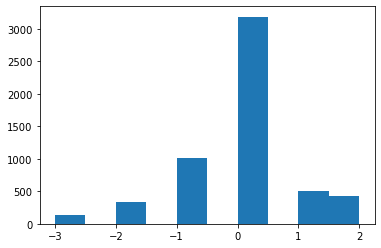

In [ ]:
plt.hist(y)

(array([ 142.,    0.,  337.,    0., 1005.,    0., 3185.,    0.,  508.,
         435.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

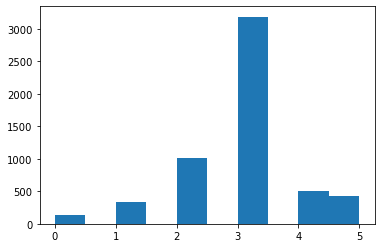

In [ ]:
# shift SBS label: multiclass classifier needs labels to start from 0
y += 3
plt.hist(y)

In [26]:
import numpy as np
from sklearn.linear_model import RidgeClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sktime.datasets import load_basic_motions  # multivariate dataset
from sktime.transformations.panel.rocket import Rocket
import xgboost as xgb

# preserve class ratio in train and test set
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(X_train.shape)
print(y_train.shape)

# verify that training and test groups have the same class distribution
# plt.hist(y_train)
# plt.show()
# plt.hist(y_test)

(4489, 3, 30)
(4489,)


XGBoost:
- [Workflow tutorial](https://xgboost.readthedocs.io/en/stable/python/python_intro.html)
- [Hyperparameter list](https://xgboost.readthedocs.io/en/stable/parameter.html)

- [Hyperparameter tuning tutorial (Section 2)](https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663)

In [ ]:
rocket = Rocket()
rocket.fit(X_train)
# transform patient waveform into features using ROCKET
X_train_transform = rocket.transform(X_train)
X_test_transform = rocket.transform(X_test)

In [ ]:
# use a simple linear classifier with regularization
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
classifier.fit(X_train_transform, y_train)
classifier.score(X_test_transform, y_test)

0.4541406945681211

In [39]:
# use xgboost classifier
dtrain = xgb.DMatrix(X_train_transform, label=y_train)
dtest = xgb.DMatrix(X_test_transform, label=y_test)
evallist = [(dtrain, 'train'), (dtest, 'eval')]

evalset = [(X_train_transform, y_train), (X_test_transform, y_test)]

param = {'n_estimators': 30,
         'max_depth': 10, 
         'learning_rate': 0.2,          # try 0.01, 0.1, and 1 first
         'colsample_bytree': 1,
         'subsample': 0.9,
         'gamma': 10,
         'objective': 'multi:softmax', 
         'num_class': 6,
         'eval_metric': 'auc'}

# double * to unpack param
model = xgb.XGBClassifier(**param)
model.fit(X_train_transform, y_train, eval_set=evalset)
# bst = xgb.train(param, dtrain, num_round, evallist)

# observe that as train AUC increase, eval AUC decrease
# this indicates model overfitting (or the data is fundamentally different)
# more model tuning is required

[0]	validation_0-auc:0.78030	validation_1-auc:0.59194
[1]	validation_0-auc:0.81769	validation_1-auc:0.60039
[2]	validation_0-auc:0.85057	validation_1-auc:0.61004
[3]	validation_0-auc:0.87923	validation_1-auc:0.61857
[4]	validation_0-auc:0.88848	validation_1-auc:0.62009
[5]	validation_0-auc:0.89626	validation_1-auc:0.62265
[6]	validation_0-auc:0.90368	validation_1-auc:0.61963
[7]	validation_0-auc:0.91083	validation_1-auc:0.62607
[8]	validation_0-auc:0.91497	validation_1-auc:0.62705
[9]	validation_0-auc:0.91973	validation_1-auc:0.63062
[10]	validation_0-auc:0.92280	validation_1-auc:0.63007
[11]	validation_0-auc:0.92694	validation_1-auc:0.63185
[12]	validation_0-auc:0.92980	validation_1-auc:0.63397
[13]	validation_0-auc:0.93413	validation_1-auc:0.63888
[14]	validation_0-auc:0.93896	validation_1-auc:0.64006
[15]	validation_0-auc:0.94286	validation_1-auc:0.64094
[16]	validation_0-auc:0.94607	validation_1-auc:0.64102
[17]	validation_0-auc:0.94806	validation_1-auc:0.64045
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=10, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=30, n_jobs=0,
              num_class=6, num_parallel_tree=1, objective='multi:softmax',
              predictor='auto', random_state=0, ...)

Accuracy: 0.565


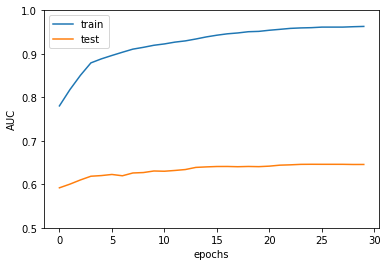

In [40]:
# evaluate performance
yhat = model.predict(X_test_transform)
score = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % score)
# retrieve performance metrics
results = model.evals_result()
# we can save this into a list, or plot it

# plot learning curves
plt.plot(results['validation_0']['auc'], label='train')
plt.plot(results['validation_1']['auc'], label='test')
plt.xlabel('epochs')
plt.ylabel('AUC')
# plot from 0 to 1
plt.ylim(0.5,1)
# show the legend
plt.legend()
# show the plot
plt.show()

Lots of automation can be done with this --> read the paper to get more info on that
Better visualization if output can plotted rather than printed out